In [1]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import string
import re
import numpy as np

2024-07-02 15:34:22.555602: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 15:34:22.555630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 15:34:22.556631: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 15:34:22.562152: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 15:34:23.348052: W tensorflow/compiler/tf2

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print("GPU is", "AVAILABLE" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.15.0

GPU is AVAILABLE


2024-07-02 15:34:25.684232: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-02 15:34:25.719269: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-02 15:34:25.719481: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
df = pd.read_csv("data/eng-french.csv")
df.head(5)

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [4]:
df['source'] = df['English words/sentences']
df['target'] = df['French words/sentences'].apply(lambda x: '[start] ' + x + ' [end]')
df = df.drop(['English words/sentences', 'French words/sentences'], axis=1)
df.sample(5)

,source,target
25570,She wants to dance.,[start] Elle a envie de danser. [end]
25351,No one looks happy.,[start] Personne n'a l'air content. [end]
96062,I can't come to work tomorrow.,[start] Je ne peux pas venir travailler demain...
71943,Tom is a regular customer.,[start] Tom est un client régulier. [end]
12526,This is our car.,[start] C'est notre voiture. [end]


In [5]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)
df.head(5)

,source,target
0,The button battery for my computer's timer died.,[start] La pile-bouton de l'horloge de mon ord...
1,I only have one suggestion.,[start] Je n'ai qu'une suggestion. [end]
2,He refused to pay.,[start] Il se refusa à payer. [end]
3,Stop joking around.,[start] Arrête de chahuter ! [end]
4,When did he go to Europe?,[start] Quand est-il allé en Europe ? [end]


In [6]:
# split the data into train, validation, and test sets
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)
test_size = int(len(df) * 0.1)
train_size, val_size, test_size

(122934, 35124, 17562)

In [7]:
train_df = df[:train_size]
val_df = df[train_size:train_size + val_size]
test_df = df[train_size + val_size:]

In [8]:
train_df.head(5)

,source,target
0,The button battery for my computer's timer died.,[start] La pile-bouton de l'horloge de mon ord...
1,I only have one suggestion.,[start] Je n'ai qu'une suggestion. [end]
2,He refused to pay.,[start] Il se refusa à payer. [end]
3,Stop joking around.,[start] Arrête de chahuter ! [end]
4,When did he go to Europe?,[start] Quand est-il allé en Europe ? [end]


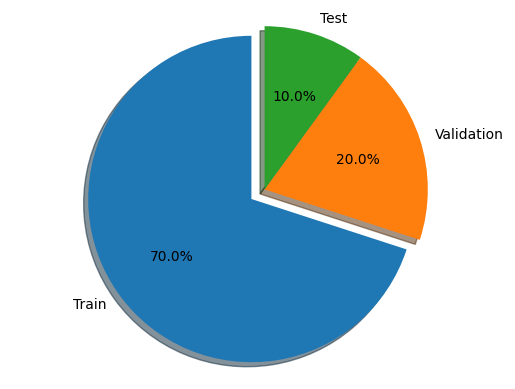

In [9]:
# Display the data sets representations using a pie chart just to see the distribution of the data
labels = 'Train', 'Validation', 'Test'
sizes = [len(train_df), len(val_df), len(test_df)]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
plt.show()

In [10]:
max_tokens = 25000
sequence_length = 30

# define a custom standardization function that convert to lowercase and strips all punctuations except "[" and "]" (so we can tell apart "start" from "[start]").
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

In [11]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

In [12]:
# tokenize the data using our custom standardization function
source_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    # add +1 token to our target sentences since they'll be shifted right by 1 during training
    standardize=custom_standardization,
)

2024-07-02 15:34:30.073590: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-02 15:34:30.073797: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-02 15:34:30.073948: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [13]:
# index all tokens in the source and target sentences
train_source_texts = train_df['source'].values
train_target_texts = train_df['target'].values
train_source_texts

array(["The button battery for my computer's timer died.",
       'I only have one suggestion.', 'He refused to pay.', ...,
       'Why would I want to sue you?',
       "You don't know what you're missing.",
       "I'm guessing this is yours."], dtype=object)

In [14]:
source_vectorization.adapt(train_source_texts)
target_vectorization.adapt(train_target_texts)
source_vectorization

In [15]:
random_sample = random.randint(0, len(train_df))
random_sample

89467

In [16]:
print("Source texts (one random sample):", train_source_texts[random_sample])
print("Target texts (one random sample):", train_target_texts[random_sample])
print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))

Source texts (one random sample): I am accustomed to living alone.
Target texts (one random sample): [start] Je suis habitué à vivre seul. [end]
Source vectors (one random sample): tf.Tensor(
[   2  118 1647    4  519  182    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(30,), dtype=int64)
Target vectors (one random sample): tf.Tensor(
[   2    4   26 1221    9  380  179    3    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(31,), dtype=int64)


In [17]:
# source_vectorization.get_vocabulary()

In [18]:
# Display the decoding of the vectorized text (from vector back to text) just to test the vectorization
source_decoded_text = ''
for i in range(len(source_vectorization(train_source_texts[random_sample]))):
    source_decoded_text += source_vectorization.get_vocabulary()[
                               source_vectorization(train_source_texts[random_sample])[i]] + ' '
print("Source decoded texts (one random sample):", source_decoded_text)

target_decoded_text = ''
for i in range(len(target_vectorization(train_target_texts[random_sample]))):
    target_decoded_text += target_vectorization.get_vocabulary()[
                               target_vectorization(train_target_texts[random_sample])[i]] + ' '
print("Target decoded texts (one random sample):", target_decoded_text)

Source decoded texts (one random sample): i am accustomed to living alone                         
Target decoded texts (one random sample): [start] je suis habitué à vivre seul [end]                        


In [19]:
# Display the shape of our vectorized data
train_source_vectors = source_vectorization(train_source_texts)
train_target_vectors = target_vectorization(train_target_texts)
print("Source vectors (shape):", train_source_vectors.shape)
print("Target vectors (shape):", train_target_vectors.shape)

Source vectors (shape): (122934, 30)
Target vectors (shape): (122934, 31)


# Building the Transformer

**Positional Embedding**

In [20]:
class PositionalEmbedding(keras.layers.Layer):
    
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = keras.layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        
    def call(self, inputs):
        embedded_tokens = self.token_embeddings(inputs)
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # create the positional information
        embedded_positions = self.position_embeddings(positions) # embed the positions 
        return embedded_tokens + embedded_positions # add the token and position embeddings to create the positional embeddings
        
    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
        })
        return config

In [21]:
# Display a random sample before and after embbeding just to test our class
embed_dim = 256
with tf.device('cpu:0'):
    train_source_embedded = PositionalEmbedding(
        sequence_length=sequence_length,
        input_dim=max_tokens,
        output_dim=embed_dim,
        name="source_embedding",
    ) (train_source_vectors)

    train_target_embedded = PositionalEmbedding(
        sequence_length=sequence_length,
        input_dim=max_tokens,
        output_dim=embed_dim,
        name="target_embedding",
    ) (train_source_vectors)

    random_sample = random.randint(0, len(train_df))
    print("Source texts (one random sample):", train_source_texts[random_sample])
    print("Target texts (one random sample):", train_target_texts[random_sample])
    print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
    print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))
    print("Source embedded vectors (one random sample):", train_source_embedded[random_sample])
    print("Target embedded vectors (one random sample):", train_target_embedded[random_sample])

2024-07-02 15:34:41.165111: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3776532480 exceeds 10% of free system memory.
2024-07-02 15:34:41.380721: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3776532480 exceeds 10% of free system memory.
2024-07-02 15:34:41.909040: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3776532480 exceeds 10% of free system memory.
2024-07-02 15:34:42.111225: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3776532480 exceeds 10% of free system memory.


Source texts (one random sample): The party's over.
Target texts (one random sample): [start] La fête est finie. [end]
Source vectors (one random sample): tf.Tensor(
[   5 5339  178    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(30,), dtype=int64)
Target vectors (one random sample): tf.Tensor(
[   2   10  294   15 3623    3    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0], shape=(31,), dtype=int64)
Source embedded vectors (one random sample): tf.Tensor(
[[-0.00650704  0.01890611  0.04230333 ...  0.03570325 -0.00179838
  -0.00820101]
 [ 0.01616565  0.0315378   0.05838604 ... -0.0440284   0.06817309
   0.09248477]
 [ 0.03959115 -0.06508946  0.00781979 ...  0.02839359  0.04449531
  -0.03617071]
 ...
 [-0.00736199 -0.0147505   0.04904447 ...  0.02357408 -0.04441813
   0.01642568]
 [ 0.06363912 -0.01061284  0.025660

In [22]:
# Display the shape of our embedded data just to test the class
print("Source embedded vectors (shape):", train_source_embedded.shape)
print("Target embedded vectors (shape):", train_target_embedded.shape)

Source embedded vectors (shape): (122934, 30, 256)
Target embedded vectors (shape): (122934, 30, 256)


**The Attention mechanism**

**1. Causal Masking**

In [23]:
# credits to OpenAI for that one (https://github.com/openai/gpt-2/blob/master/src/model.py)
def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

def attention_mask(nd, ns, *, dtype):
    """1's in the lower triangle, counting from the lower right corner.
    Same as tf.matrix_band_part(tf.ones([nd, ns]), -1, ns-nd), but doesn't produce garbage on TPUs.
    """
    i = tf.range(nd)[:,None]
    j = tf.range(ns)
    m = i >= j - ns + nd
    return tf.cast(m, dtype)

def mask_attn_weights(w):
    # w has shape [batch, heads, dst_sequence, src_sequence], where information flows from src to dst.
    _, _, nd, ns = shape_list(w)
    b = attention_mask(nd, ns, dtype=w.dtype)
    b = tf.reshape(b, [1, 1, nd, ns])
    w = w*b - tf.cast(1e10, w.dtype)*(1-b)
    return w

# display the causal masking of a random tensor just to test the function
random_tensor = tf.random.uniform(shape=(1, 1, 5, 5), minval=0, maxval=1, dtype=tf.float32)
print("Masked attention weights:", mask_attn_weights(random_tensor))

**2. Scaled Dot-Product Attention**

In [24]:
def scaled_dot_product_attention(q, k, v, use_causal_mask=False):
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scores = tf.matmul(q, k, transpose_b=True) # Matmul of Q and K
    scaled_scores = scores / tf.math.sqrt(d_k) # Scale
    if use_causal_mask:
        scaled_scores = mask_attn_weights(scaled_scores) # Mask (opt.)
    weights = tf.nn.softmax(scaled_scores, axis=-1) # SoftMax
    output = tf.matmul(weights, v) # Matmul of SoftMax and V
    return output

In [25]:
# display the shape of our attention output just to test the function
with tf.device('cpu:0'):
    input = train_source_embedded
    input = tf.expand_dims(input, axis=1)
    print("Scaled dot product attention (shape):", scaled_dot_product_attention(input, input, input, use_causal_mask=True).shape)

2024-07-02 15:34:48.800199: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 3776532480 exceeds 10% of free system memory.


Scaled dot product attention (shape): (122934, 1, 30, 256)


**3. Multi-Head Attention**

In [26]:
class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, embed_dim, h, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.h = h
        if embed_dim % h != 0:
            raise ValueError(
                f"dimension of the embedding space = {embed_dim} should be divisible by number of heads = {h}"
            )
        self.q_linear = keras.layers.Dense(embed_dim)
        self.k_linear = keras.layers.Dense(embed_dim)
        self.v_linear = keras.layers.Dense(embed_dim)
        self.concat_linear = keras.layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, shape=(batch_size, -1, self.h, self.embed_dim // self.h))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def concat_heads(self, x, batch_size):
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(x, (batch_size, -1, self.embed_dim))

    def call(self, q, k, v, use_causal_mask=False):
        batch_size = tf.shape(k)[0]
        q = self.q_linear(q)
        k = self.k_linear(k)
        v = self.v_linear(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        attention = scaled_dot_product_attention(q, k, v, use_causal_mask)
        concat = self.concat_heads(attention, batch_size)
        concat = self.concat_linear(concat)
        return concat

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "h": self.h,
        })
        return config

**The Encoder**

In [27]:
class TransformerEncoder(keras.layers.Layer):
    
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.layer_norm_1 = keras.layers.LayerNormalization()
        self.layer_norm_2 = keras.layers.LayerNormalization()
        self.global_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = keras.Sequential(
            [keras.layers.Dense(dense_dim, activation="relu"),
             keras.layers.Dense(embed_dim),]
        )
        
    def call(self, x):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.global_self_attention(q=x, k=x, v=x))
        x = self.layer_norm_2(x + self.feed_forward(x))
        return x
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

**The Decoder**

In [28]:
class TransformerDecoder(keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.causal_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.cross_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = keras.Sequential(
            [keras.layers.Dense(dense_dim, activation="relu"),
             keras.layers.Dense(embed_dim),]
        )
        self.layer_norm_1 = keras.layers.LayerNormalization()
        self.layer_norm_2 = keras.layers.LayerNormalization()
        self.layer_norm_3 = keras.layers.LayerNormalization()

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

    def call(self, x, context):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.causal_self_attention(q=x, k=x, v=x, use_causal_mask=True))
        x = self.layer_norm_2(x + self.cross_attention(q=x, k=context, v=context))
        x = self.layer_norm_3(x + self.feed_forward(x))
        return x

In [29]:
batch_size = 64

def format_dataset(source, target):
    source_vectors = source_vectorization(source)
    target_vectors = target_vectorization(target)
    return ({
        "source": source_vectors, # encoder_inputs
        "target": target_vectors[:, :-1], # decoder_inputs (truncate by 1 to keep it at the same length as decoder_outputs, which is shifted right by 1).
    }, target_vectors[:, 1:]) # decoder_outputs

def make_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df["source"].values, df["target"].values))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_df)
val_ds = make_dataset(val_df)

In [30]:
train_ds

<CacheDataset element_spec=({'source': TensorSpec(shape=(None, 30), dtype=tf.int64, name=None), 'target': TensorSpec(shape=(None, 30), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 30), dtype=tf.int64, name=None))>

In [31]:
# display the shape of the first batch of data in the dataset just to see what it looks like
for batch in train_ds.take(1):
    print("Encoder Inputs:", batch[0]["source"].shape)
    print("Decoder Inputs:", batch[0]["target"].shape)
    print("Decoder Outputs:", batch[1].shape)

Encoder Inputs: (64, 30)
Decoder Inputs: (64, 30)
Decoder Outputs: (64, 30)


2024-07-02 15:34:55.390659: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [32]:
embed_dim = 512 # dimension of the embedding space
dense_dim = 2048 # dimension of the feed forward network (a rule of thumb is to use 4 times the size of the embeddings)
num_heads = 8

# the transformer body
encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="source")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="target")
x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)

# the transformer head
x = keras.layers.Dropout(0.5)(x)
decoder_outputs = keras.layers.Dense(max_tokens, activation="softmax")(x)

transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [33]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

EPOCHS = 10
checkpoint_filepath = 'checkpoint.weights.h5'
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    ),
]
    
transformer.fit(train_ds, 
                epochs=EPOCHS, 
                callbacks=callbacks_list,
                validation_data=val_ds)

transformer.load_weights(checkpoint_filepath)

Epoch 1/10


2024-07-02 15:35:11.648381: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-07-02 15:35:12.177209: I external/local_xla/xla/service/service.cc:168] XLA service 0x7a7d7abc6fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-02 15:35:12.177231: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-07-02 15:35:12.181358: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1719927312.233318  276714 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1921/1921 [==============================] - 142s 72ms/step - loss: 0.9398 - accuracy: 0.8595 - val_loss: 0.5872 - val_accuracy: 0.9001 - lr: 0.0010
Epoch 2/10
1921/1921 [==============================] - 137s 71ms/step - loss: 0.5649 - accuracy: 0.9027 - val_loss: 0.4908 - val_accuracy: 0.9114 - lr: 0.0010
Epoch 3/10
1921/1921 [==============================] - 138s 72ms/step - loss: 0.4680 - accuracy: 0.9143 - val_loss: 0.4582 - val_accuracy: 0.9163 - lr: 0.0010
Epoch 4/10
1921/1921 [==============================] - 140s 73ms/step - loss: 0.4104 - accuracy: 0.9219 - val_loss: 0.4352 - val_accuracy: 0.9199 - lr: 0.0010
Epoch 5/10
1921/1921 [==============================] - 140s 73ms/step - loss: 0.3686 - accuracy: 0.9276 - val_loss: 0.4270 - val_accuracy: 0.9215 - lr: 0.0010
Epoch 6/10
1921/1921 [==============================] - 140s 73ms/step - loss: 0.3352 - accuracy: 0.9323 - val_loss: 0.4271 - val_accuracy: 0.9235 - lr: 0.0010
Epoch 7/10
1921/1921 [=============================

In [34]:
target_vocab = target_vectorization.get_vocabulary()
target_index_lookup = dict(zip(range(len(target_vocab)), target_vocab))
max_decoded_sentence_length = 30

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = target_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence

In [35]:
# let's translate 50 random sentences
for i in range(50):
    random_index = np.random.randint(0, len(test_df))
    input_sentence = test_df["source"].iloc[random_index]
    print(input_sentence)
    print(decode_sequence(input_sentence))
    print()

She sang a Japanese song for us.
[start] elle a chanté une chanson pour nous [end]

I just felt a little dizzy. That's all.
[start] je me suis un peu senti que cest tout [end]

He has no conscience.
[start] il na aucune conscience [end]

Can you tell me why Tom isn't here?
[start] peuxtu me dire pourquoi tom nest pas là [end]

This is giving me a headache.
[start] Ça me donne mal à la tête [end]

They will agree on that.
[start] ils vont daccord sur ça [end]

She won't make it.
[start] elle ne le fera pas [end]

Who makes the decisions here?
[start] qui fait des décisions ici [end]

Tom doesn't like frog legs.
[start] tom naime pas la différence les jambes [end]

Can you do a headstand?
[start] peuxtu te faire la tête [end]

Take that back.
[start] prends ce nest [end]

I sometimes hear my father singing in the bath.
[start] jentends parfois mon père chanter dans le bain [end]

Tom's well.
[start] tom est bien [end]

Tom makes a lot of spelling mistakes.
[start] tom fait de nombreuses 